In [61]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import jax
import scipy.linalg
import json
import argparse
import sys
sys.argv = sys.argv[:1]
import jax.numpy as jnp
from jax.scipy.linalg import sqrtm
from cmath import exp
from scipy.optimize import minimize
from jax.scipy.linalg import sqrtm
from scipy.linalg import expm, logm
import numpy as np
from numpy import pi
from scipy.linalg import expm, logm, sqrtm
import jax.numpy as jnp
from jax.scipy.linalg import expm as jexp
from jax import grad, jit, jacfwd
import itertools as it

In [62]:
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0,-1j],[1j,0]])

In [63]:

def lindblad_depol_list(tau):
    """
    Returns Lindblad operators for depolarizing noise.
    """
    M  = 0.5 / np.sqrt(tau)
    return [M*X, M*Y, M*Z] 
def lindblad_damp_list(tau):
    """
    Returns Lindblad operators for damping noise.
    """
    M  = 0.5 / np.sqrt(tau)
    return [M*(X + 1.j*Y)] 
def lindblad_deph_list(tau):
    """
    Returns Lindblad operators for dephasing noise.
    """
    M  = 0.5 / np.sqrt(tau)
    return [M*Z] 

In [64]:
def diss_from_list(list,d):
    S = np.zeros((d**2, d**2), dtype=np.complex128)
    t = np.eye(d // 2) * (d // 2)
    for i in range(len(list)):
        A_k = jnp.kron(jnp.kron(t,list[i]), jnp.conjugate(jnp.kron(t,list[i]))) - 1 / 2 * (
            jnp.kron(jnp.dot(jnp.conjugate(jnp.kron(t,list[i])).T, jnp.kron(t,list[i])), np.eye(d)) +
            jnp.kron(np.eye(d), jnp.dot((jnp.kron(t,list[i])).T, jnp.conjugate(jnp.kron(t,list[i])))))
        S += A_k
    return S
    

def gellmann(j, k, d, sparse=False):
    """
    Generates a generalized Gell-Mann matrix.
    
    """
    if j > k:
        coords = [[j - 1, k - 1],
                  [k - 1, j - 1]]
        data = [1, 1]
    elif k > j:
        coords = [[j - 1, k - 1],
                  [k - 1, j - 1]]
        data = [-1j, 1j]
    elif j == k and j < d:
        coords = [list(range(j + 1)),
                  list(range(j + 1))]
        data = np.sqrt(2 / (j * (j + 1))) * np.array(list(it.repeat(1 + 0j, j))
                                                     + [-j + 0j])
    else:
        coords = [list(range(d)),
                  list(range(d))]
        data = list(it.repeat(1 + 0j, d))

    if sparse:
        gjkd = COO(coords, data, shape=(d, d))
    else:
        gjkd = np.zeros((d, d), dtype=np.complex128)
        for val, m, n in zip(data, *coords):
            gjkd[m][n] = val

    return gjkd


def get_basis(d, sparse=False):
    """
    Returns the Gell-Mann basis for dimension d.

    """
    return [gellmann(j, k, d, sparse)
            for j, k in it.product(range(1, d + 1), repeat=2)]


def delta_h_d(x_dh):
    """
    Сreating an amendment to the Hamiltonian.
    
    """
    mtr = get_basis(int(np.sqrt(len(x_dh) + 1)))
    return sum(x_dh[i] * mtr[i] for i in range(0, len(x_dh)))


def matprint(mat, fmt="g"):
    """
    Prints a matrix with a given label.
    
    """
    col_maxes = [max([len(("{:" + fmt + "}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:" + str(col_maxes[i]) + fmt + "}").format(y), end="  ")
        print("")


def get_choi(ch, d):
    """
    Getting the Choi matrix from the channel.
    
    """
    choi = np.reshape(ch, (d, d, d, d))
    choi = np.transpose(choi, (0, 2, 1, 3))
    choi = np.reshape(choi, (d ** 2, d ** 2))
    return choi


def read_info(file_name):
    """
    Loads JSON-formatted input data from file.

    """
    with open(file_name, "r") as read_file:
        info = json.load(read_file)
    return info

In [65]:
DESCRIPTION = """
The script performs reconstruction of a Markovian generator (both unitary and dissipative parts) 
for a given channel of a gate and provides the corresponding non-Markovianity measure.
"""

In [66]:
def main():
    parser = argparse.ArgumentParser(
        description=DESCRIPTION,
        formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('-i', '--input', default='test2-d=2.json',
                        help='Path to file containing input information'
                             '(.json)')
    parser.add_argument('-o', '--output', default='output.json',
                        help='Path to file containing output information'
                             '(.json)')
    parser.add_argument("-v", "--verbosity", action="count", default=0,
                        help='Verbosity parameter')
    args = parser.parse_args()

    input_file_name = args.input
    output_file_name = args.output
    global ch_matr_im, ch_matr_re, unit_gen_im, unit_gen_re, tau, d
    input_info = read_info(input_file_name)
    d = input_info["d"]
    target_matrix = get_choi(np.array(input_info["choi_matr_re"]) + 1j * np.array(input_info["choi_matr_im"]), d)
    tau = input_info["unitary_time"]
    unit_gen_re = input_info["unitary_gen_re"]
    unit_gen_im  = input_info["unitary_gen_im"]
    ch_matr_re = input_info["choi_matr_re"]
    ch_matr_im = input_info["choi_matr_im"]
    hmlt = np.array(input_info["unitary_gen_re"]) + 1j * np.array(input_info["unitary_gen_im"])

    x0 = np.random.rand(d ** 2 - 1 + 2 * (d ** 2 - 1) ** 2)

    A = get_basis(d)
    
    def get_lindbladian_term(i, j):
        """
        Constructs the elementary term of the dissipator.
        """
        return jnp.kron(A[i], jnp.conjugate(A[j])) - 1 / 2 * (      
                jnp.kron(jnp.dot(A[j], A[i]), np.eye(d)) +
                jnp.conjugate(jnp.kron(np.eye(d), jnp.dot(A[i], A[j]))))

    lindbladian_term = np.empty((d ** 2 - 1, d ** 2 - 1, d ** 2, d ** 2), dtype=np.complex128)
    for i in range(0, d ** 2 - 1):
        for j in range(0, d ** 2 - 1):
            lindbladian_term[i, j] = get_lindbladian_term(i, j)

    
    def dissipator_complex(x):
        """
        Returns superoperator form of a complex Lindblad operator.
        """
        x_re = x[0:(d ** 2 - 1) ** 2].reshape(d ** 2 - 1, d ** 2 - 1)
        x_im = x[(d ** 2 - 1) ** 2:2 * (d ** 2 - 1) ** 2].reshape(d ** 2 - 1, d ** 2 - 1)

        x_matrix_form_t = x_re + 1j * x_im
        x_matrix_form = (x_matrix_form_t.transpose()).conj() @ x_matrix_form_t
        diss = np.zeros((d ** 2, d ** 2), dtype=np.complex128)
        n = x_matrix_form.shape
        for i in range(d ** 2 - 1):
            for j in range(d ** 2 - 1):
                diss += x_matrix_form[i, j] * lindbladian_term[i, j]
        return diss

    @jit
    def jax_phi_gate_j_dissipator(gate, x):
        """
        Calculates the type of channel obtained by adding corrections described by the vector
        of parameters x to the channel of the ideal gate.
        """
        hamiltonian, tau = gate
        Id = jnp.eye(len(hamiltonian))
        x_dh = jnp.array(x[0:d ** 2 - 1])
        x_diss = jnp.array(x[d ** 2 - 1:d ** 2 - 1 + 2 * (d ** 2 - 1) ** 2])
        ham_dh = hamiltonian + delta_h_d(x_dh)
        logm_phi_j = tau * dissipator_complex(x_diss) -1j * tau * (jnp.kron(ham_dh, Id) - jnp.kron(Id, jnp.conj(ham_dh)))

        return jexp(logm_phi_j)

    @jit
    def cost_f(xx):
        """
        Cost function for optimization problem.
        """
        matr = target_matrix - jax_phi_gate_j_dissipator([hmlt, tau], xx)
        return jnp.linalg.norm(matr, 'fro') + 0.4*jnp.linalg.norm(np.imag(dissipator_complex(xx))) #+ jnp.linalg.norm(jax_phi_gate_j_dissipator([hmlt, tau], xx), 'fro')

    jac_case = jit(jacfwd(cost_f))

    res = minimize(cost_f, 1e-3 * x0, jac=jac_case, method='COBYLA', options={'maxiter':1000})



    res.hess_inv = None
    dissipator = dissipator_complex(res.x[d ** 2 - 1:d ** 2 - 1 + 2 * (d ** 2 - 1) ** 2])
    global est_diss
    est_diss = dissipator
    results = {'unitary_gen_descr_re': (np.asarray(np.real(delta_h_d(res.x[0:d ** 2 - 1])))).tolist(),
               'unitary_gen_descr_im': (np.asarray(np.imag(delta_h_d(res.x[0:d ** 2 - 1])))).tolist(),
               'dissipator_re': (np.asarray(np.real(dissipator / np.linalg.norm(dissipator, 'fro')))).tolist(),
               'dissipator_im': (np.asarray(np.imag(dissipator / np.linalg.norm(dissipator, 'fro')))).tolist(),
               'dissipator_norm': np.linalg.norm(dissipator, 'fro'),
               'dec_str_cur': np.real(1 - exp(-np.linalg.norm(dissipator, 'fro') / d)),
               'dec_str_min': 0,
               'dec_str_max': 1,
               'non_markovianity': res.fun}
    with open(output_file_name, 'w') as stats_file:
        json.dump(results, stats_file)

    results_matrixes_rounded = {'unitary_gen_descr_re': (np.asarray(np.real(delta_h_d(res.x[0:d ** 2 - 1]))).round(3)),
                                'unitary_gen_descr_im': (np.asarray(np.imag(delta_h_d(res.x[0:d ** 2 - 1]))).round(3)),
                                'dissipator_re': (
                                    np.asarray(np.real(dissipator / np.linalg.norm(dissipator, 'fro'))).round(3)),
                                'dissipator_im': (
                                    np.asarray(np.imag(dissipator / np.linalg.norm(dissipator, 'fro'))).round(3))}

    for key, value in results_matrixes_rounded.items():
        print(key, ':')
        matprint(value)
        print('\n')

    results_numbers_rounded = {'dissipator_norm': ((np.linalg.norm(dissipator, 'fro')).round(4)),
                               'dec_str_cur': round(((np.real(1 - exp(-np.linalg.norm(dissipator, 'fro') / d)))), 4),
                               'dec_str_min': ((1.0000)),
                               'dec_str_max': ((0.0000)),
                               'non_markovianity': round(((res.fun)), 4)}

    for key, value in results_numbers_rounded.items():
        print(key, ':', value)

In [67]:
if __name__ == "__main__":
    main()

unitary_gen_descr_re :
 0.003  -0.011  
-0.011  -0.003  


unitary_gen_descr_im :
    0  -0.025  
0.025       0  


dissipator_re :
-0.204       0       0   0.201  
-0.005  -0.614  -0.202  -0.006  
-0.005  -0.202  -0.614  -0.006  
 0.204      -0      -0  -0.201  


dissipator_im :
 0  -0   0   0  
-0   0  -0  -0  
 0   0   0   0  
 0   0  -0   0  


dissipator_norm : 4.8328
dec_str_cur : 0.9108
dec_str_min : 1.0
dec_str_max : 0.0
non_markovianity : 1.0568


In [68]:
get_vec = lambda f: (diss_from_list(f(tau), d) / np.abs(diss_from_list(f(tau), d)).max()).flatten('C')

D_n = np.column_stack([get_vec(f) for f in [lindblad_damp_list, lindblad_depol_list, lindblad_deph_list]])
D = est_diss.flatten('C')

In [69]:
import numpy as np
from scipy.linalg import svd


def solve_linear_system_svd(X_n: np.ndarray, X: np.ndarray, tol: float = 1e-12) -> np.ndarray:
    """
    Solves the redefined linear system X_n @ x ≈ X 
    using stable SVD and filtering of small singular values.
    """
    U, s, Vt = svd(X_n, full_matrices=False)
    s_inv = np.where(s > tol, 1 / s, 0.0)
    x = Vt.T @ np.diag(s_inv) @ U.T @ X
    return x

In [70]:
from scipy.linalg import svd
x = solve_linear_system_svd(D_n, D)
print("====REVERSE MATRIX method====:")
print(np.round(x/np.max(x), 4)) 

====REVERSE MATRIX method====:
[-0.0072+0.j  1.    +0.j  0.5109+0.j]


In [71]:
import numpy as np
from scipy.linalg import sqrtm


def fidelity(rho: np.ndarray, sigma: np.ndarray) -> float:
    """
    Calculates the quantum fidelity between two density matrices.
    """
    rho = np.array(rho, dtype=complex)
    sigma = np.array(sigma, dtype=complex)

    rho /= np.trace(rho)
    sigma /= np.trace(sigma)
    sqrt_rho = sqrtm(rho)
    intermediate = sqrt_rho @ sigma @ sqrt_rho
    sqrt_intermediate = sqrtm(intermediate)
    fidelity_value = np.real(np.trace(sqrt_intermediate)) ** 2
    return float(np.clip(fidelity_value, 0.0, 1.0))


In [ ]:
print(fidelity((D_n@x).reshape(d**2,d**2),est_diss))

0.9999997149125791


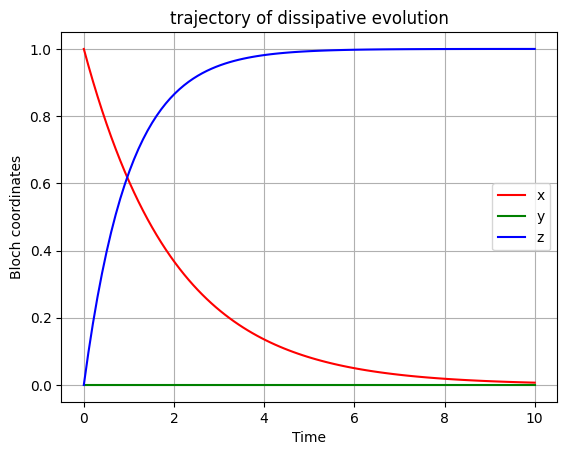

In [ ]:
import matplotlib.pyplot as plt

def draw_trajectorty(
    noise_op_lst: list[np.ndarray],
    vec0: np.ndarray,
    tstart: float = 0,
    tend: float = 10,
    tnum: int = 100,
):
    """
    Draws trajectory of qubit's Bloch coordinates for a given list of noise operators.
    """
    rho = np.array(vec0, dtype=complex)
    

    time_arr = np.linspace(tstart, tend, tnum)
    dt = time_arr[1] - time_arr[0]

    d = 2
    L = diss_from_list(noise_op_lst, d)


    bloch_coords = []
    for t in time_arr:
        L = np.array(L, dtype=complex, copy=True)
        rho_vec = np.array(rho.flatten('F'), dtype=complex, copy=True)

        rho_t_vec = expm(L * t) @ rho_vec
        rho_t = rho_t_vec.reshape(d, d, order='F')


        x = np.real(np.trace(rho_t @ X))
        y = np.real(np.trace(rho_t @ Y))
        z = np.real(np.trace(rho_t @ Z))
        bloch_coords.append([x, y, z]) 

    bloch_coords = np.array(bloch_coords)
    

    plt.plot(time_arr, bloch_coords[:, 0], label="x", color='r')
    plt.plot(time_arr, bloch_coords[:, 1], label="y", color='g')
    plt.plot(time_arr, bloch_coords[:, 2], label="z", color='b')
    plt.xlabel("Time")
    plt.ylabel("Bloch coordinates")
    plt.legend()
    plt.grid(True)
    plt.title("trajectory of dissipative evolution")
    plt.show()



# |+⟩⟨+| = (|0⟩ + |1⟩)(⟨0| + ⟨1|)/2
vec0 = np.array([[0.5, 0.5], [0.5, 0.5]], dtype=complex)  # |+⟩⟨+|
tau = 1.0

draw_trajectorty(lindblad_damp_list(tau), vec0)


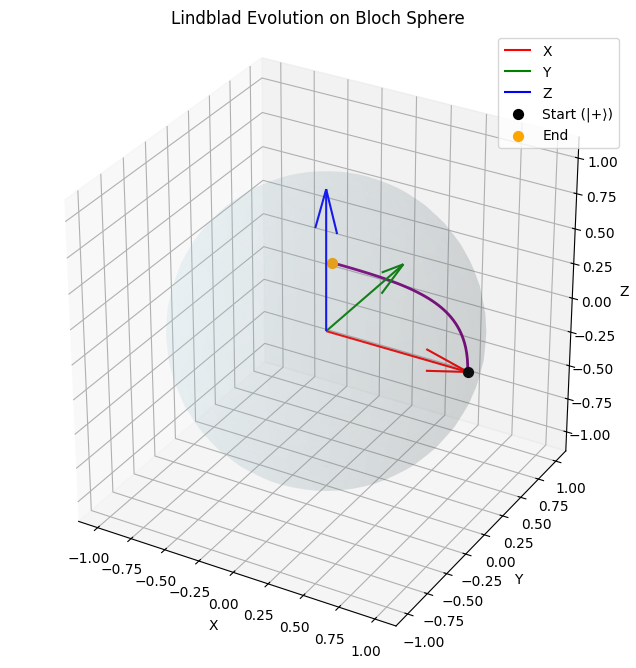

In [76]:
def draw_bloch_trajectory_3d(noise_op_lst, vec0, tstart=0, tend=10, tnum=100):
    rho = np.array(vec0, dtype=complex)
    time_arr = np.linspace(tstart, tend, tnum)

    d = 2
    L = diss_from_list(noise_op_lst, d)
    rho_vec0 = rho.flatten('F')

    bloch_coords = []
    for t in time_arr:
        rho_t_vec = expm(L * t) @ rho_vec0
        rho_t = rho_t_vec.reshape((d, d), order='F')
        x = np.real(np.trace(rho_t @ X))
        y = np.real(np.trace(rho_t @ Y))
        z = np.real(np.trace(rho_t @ Z))
        bloch_coords.append([x, y, z])

    bloch_coords = np.array(bloch_coords)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:25j]
    xs = np.cos(u)*np.sin(v)
    ys = np.sin(u)*np.sin(v)
    zs = np.cos(v)
    ax.plot_surface(xs, ys, zs, color='lightblue', alpha=0.1)


    ax.quiver(0, 0, 0, 1, 0, 0, color="r", label='X')
    ax.quiver(0, 0, 0, 0, 1, 0, color="g", label='Y')
    ax.quiver(0, 0, 0, 0, 0, 1, color="b", label='Z')

    ax.plot(bloch_coords[:, 0], bloch_coords[:, 1], bloch_coords[:, 2], color='purple', linewidth=2)

    ax.scatter(*bloch_coords[0], color='black', label='Start (|+⟩)', s=50)
    ax.scatter(*bloch_coords[-1], color='orange', label='End', s=50)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Lindblad Evolution on Bloch Sphere")
    ax.legend()
    ax.set_box_aspect([1,1,1])
    plt.show()


draw_bloch_trajectory_3d(lindblad_damp_list(tau), vec0)
